<a href="https://colab.research.google.com/github/johanjun/seoul_bike_share/blob/main/Residual_%26_Stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# DateTime
import datetime
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os
import pickle
import tqdm

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

In [2]:
import os
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


# Data Load

In [203]:
with open('/content/drive/My Drive/data/seoul_bike_sharing/df_gangdong.pkl', 'rb') as f:
  df_gangdong = pickle.load(f)

In [52]:
df_gangdong.shape

(9528, 13)

In [53]:
df_gangdong.head()

,rent_count,rent_trend,rent_seasonal,count_Day,count_Week,count_diff,DateTime,Year,Quarter,Day,DayofWeek,rent_count_lag1,rent_count_lag2
DateTime,,,,,,,,,,,,,
2020-01-01 00:00:00,32.00,23.21,-22.35,23.29,29.80,-8.00,2020-01-01 00:00:00,2020,1,1,2,32.00,32.00
2020-01-01 01:00:00,24.00,23.21,-38.56,23.29,29.80,-8.00,2020-01-01 01:00:00,2020,1,1,2,32.00,32.00
2020-01-01 02:00:00,34.00,23.21,-56.46,23.29,29.80,10.00,2020-01-01 02:00:00,2020,1,1,2,24.00,32.00
2020-01-01 03:00:00,18.00,23.21,-68.56,23.29,29.80,-16.00,2020-01-01 03:00:00,2020,1,1,2,34.00,24.00
2020-01-01 04:00:00,11.00,23.21,-78.02,23.29,29.80,-7.00,2020-01-01 04:00:00,2020,1,1,2,18.00,34.00


In [20]:
### Functionalize
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)

### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

In [54]:
Y_colname = ['rent_count']
X_remove = ['DateTime']
X_colname = [x for x in df_gangdong.columns if x not in Y_colname+X_remove]
len(X_colname)
data_train = df_gangdong.loc[df_gangdong.index < '2021-01-01', :]
data_test = df_gangdong.loc[df_gangdong.index >= '2021-01-01', :]

Y_train = data_train[Y_colname]
X_train = data_train[X_colname]
Y_test = data_test[Y_colname]
X_test = data_test[X_colname]

fit_reg1 = sm.OLS(Y_train, X_train).fit()

pred_tr_reg1 = fit_reg1.predict(X_train).values
pred_te_reg1 = fit_reg1.predict(X_test).values

pd.concat([Y_train, pd.DataFrame(pred_tr_reg1, index=Y_train.index, columns=['prediction'])], axis=1)

11

,MAE,MSE,MAPE
Train,0.00,0.01,inf
Test,0.00,0.00,inf


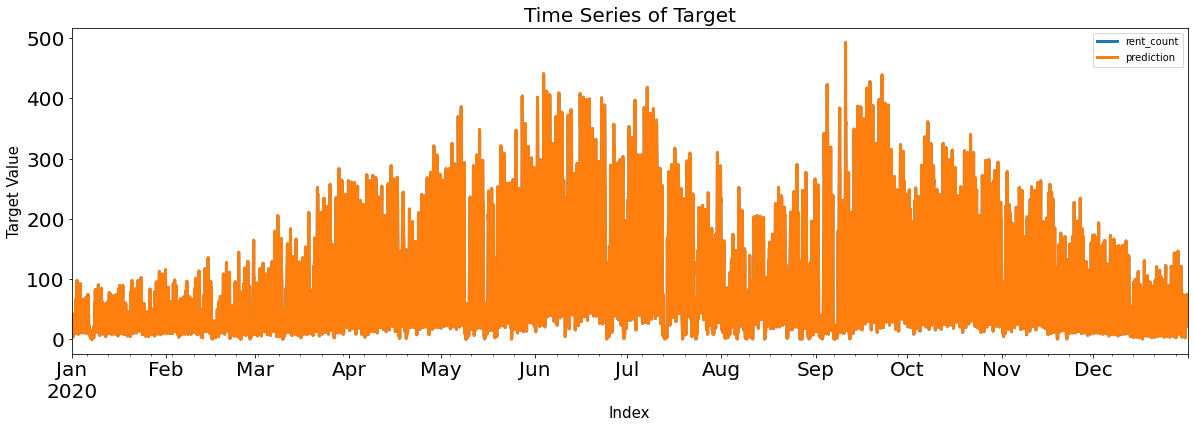

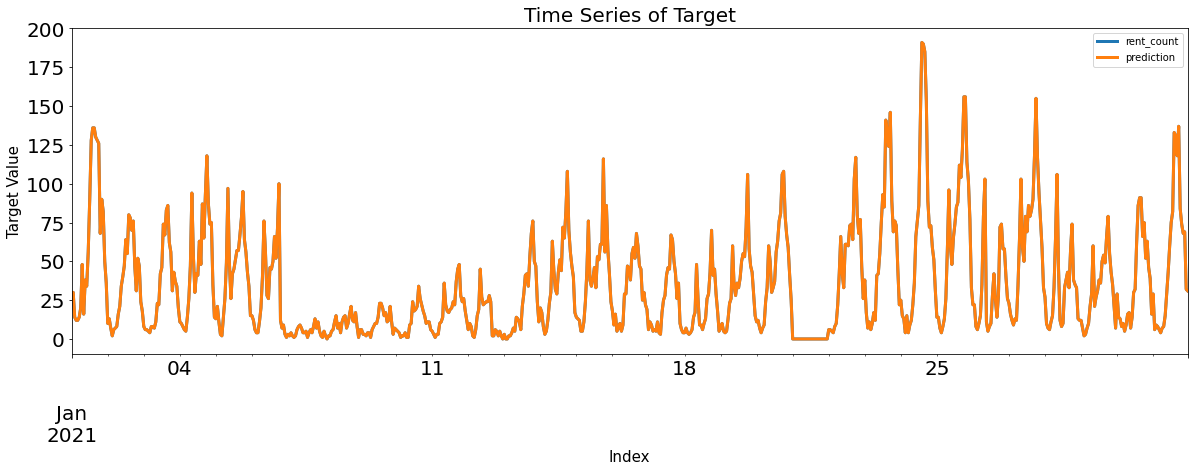

In [57]:
Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)
Score_reg1

# 잔차분석

In [59]:
Resid_tr_reg1['RowNum'] = Resid_tr_reg1.reset_index().index
Resid_tr_reg1

,Error,RowNum
DateTime,,
2020-01-01 00:00:00,7.99,0
2020-01-01 01:00:00,-0.01,1
2020-01-01 02:00:00,-0.01,2
2020-01-01 03:00:00,-0.01,3
2020-01-01 04:00:00,-0.01,4
...,...,...
2020-12-31 19:00:00,0.00,8779
2020-12-31 20:00:00,0.00,8780
2020-12-31 21:00:00,0.00,8781


## Stationarity

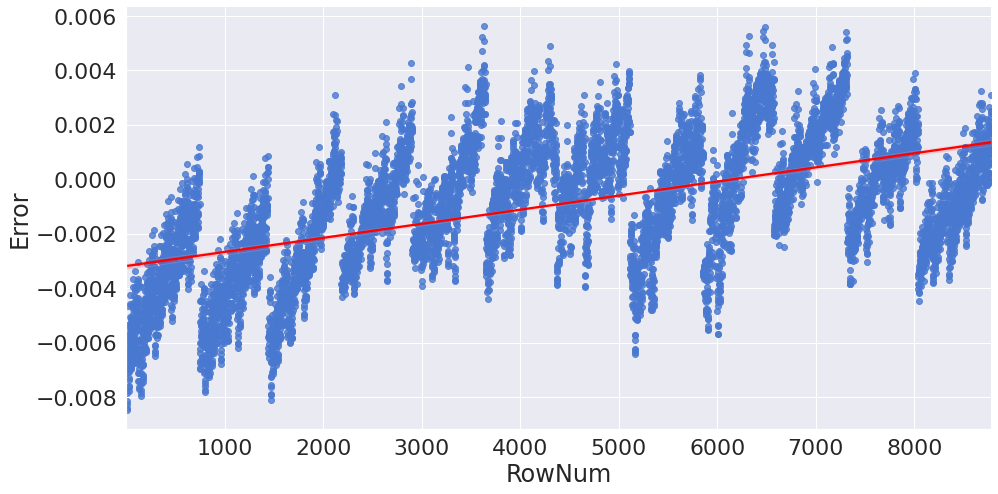

In [69]:
sns.set(palette='muted', color_codes=True, font_scale=2)
sns.lmplot(x='RowNum', y='Error', data=Resid_tr_reg1.iloc[1:], fit_reg='True', line_kws={'color' : 'red'}, size=7, ci=99, sharey=True, aspect=2)

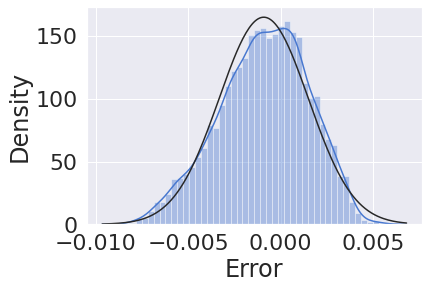

In [71]:
sns.distplot(Resid_tr_reg1['Error'].iloc[1:], norm_hist=True, fit=stats.norm)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

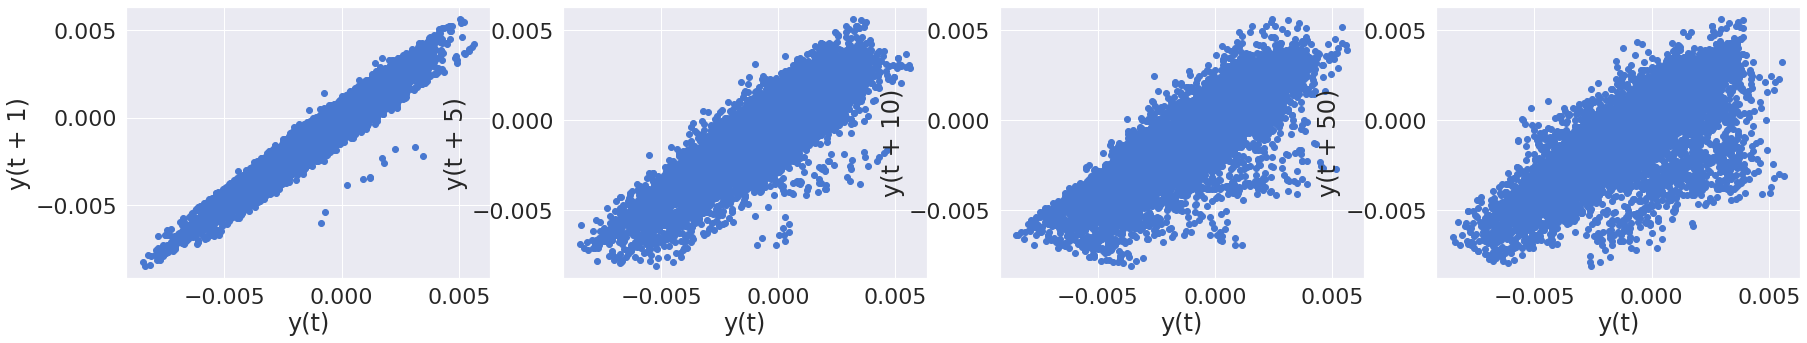

In [82]:
figure, axes = plt.subplots(1, 4, figsize=(30,5))
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=1, ax=axes[0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=5, ax=axes[1])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=10, ax=axes[2])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=50, ax=axes[3])

=> 1에서 50으로 가더라도 corr가 0이어야 한다!



## ACF, PACF

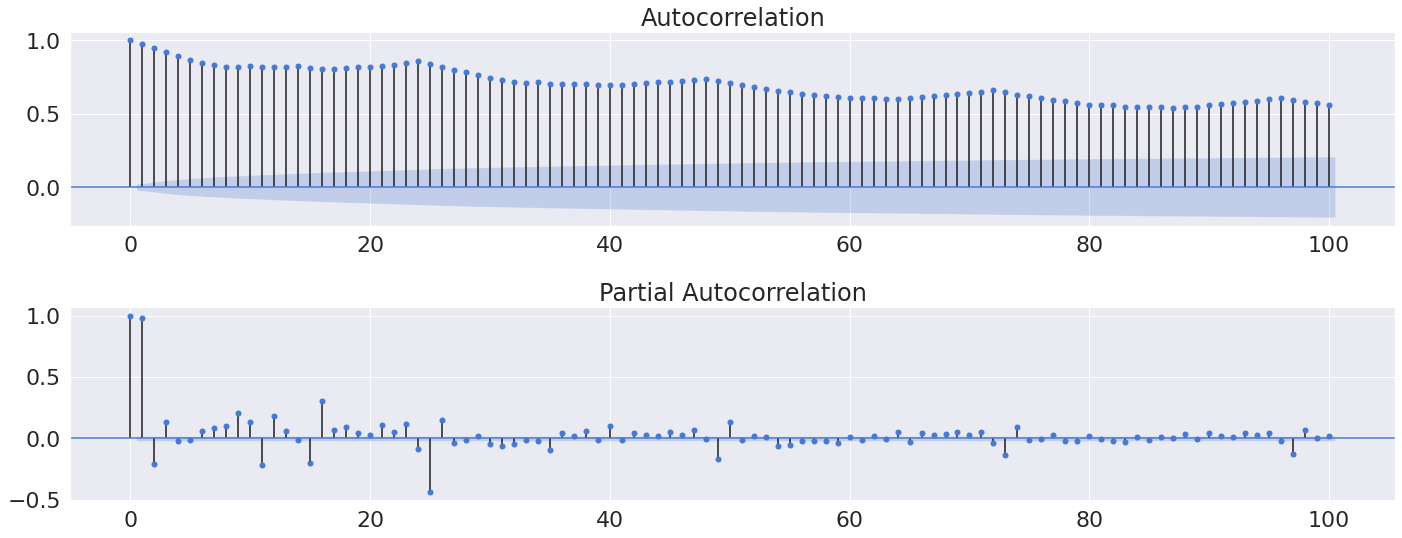

In [90]:
figure, axes = plt.subplots(2, 1, figsize=(20,8))
figure = sm.graphics.tsa.plot_acf(Resid_tr_reg1['Error'].iloc[1:], lags=100, ax=axes[0], use_vlines=True)
figure = sm.graphics.tsa.plot_pacf(Resid_tr_reg1['Error'].iloc[1:], lags=100, ax=axes[1], use_vlines=True)
plt.tight_layout()

In [139]:
Stationarity = pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'].iloc[1:])[0:4],
          index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
for key, value in sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[4].items():
  Stationarity['Critical Value(%s)'%key] = value
Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[5]
Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])
Stationarity

,Stationarity
Test Statistics,-5.57
p-value,0.00
Used Lag,37.00
Used Observations,"8,745.00"
Critical Value(1%),-3.43
Critical Value(5%),-2.86
Critical Value(10%),-2.57
Maximum Information Criteria,"-114,199.14"


In [114]:
Normality = pd.DataFrame([stats.shapiro(Resid_tr_reg1['Error'])],
                         index=['Normality'],
                         columns=['Test Statistics', 'p-value']).T
Normality

,Normality
Test Statistics,0.01
p-value,0.00


In [116]:
Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']
Autocorrelation

,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50)
Test Statistics,0.00,0.00,0.00,0.01
p-value,1.00,1.00,1.00,1.00


In [117]:
Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'].iloc[1:], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'].iloc[1:], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']
Autocorrelation

,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50)
Test Statistics,"8,396.83","37,379.18","67,484.48","273,854.20"
p-value,0.00,0.00,0.00,0.00


## 등분산성

In [121]:
Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Resid_tr_reg1['Error'], X_train.values, alternative='two-sided')],
                                  index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
Heteroscedasticity

,Heteroscedasticity
Test Statistics,0.00
p-value,0.00
Alternative,two-sided


In [140]:
Error_Analysis = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
Error_Analysis = Error_Analysis.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                                     'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)',
                                     'Maximum Information Criteria'], :]
Error_Analysis

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-5.57,0.01,"8,396.83","37,379.18","67,484.48","273,854.20",0.00
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,37.00,nan,nan,nan,nan,nan,NaN
Used Observations,"8,745.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),-2.86,nan,nan,nan,nan,nan,NaN
Critical Value(10%),-2.57,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-114,199.14",nan,nan,nan,nan,nan,NaN


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-5.57,8.81,0.99,"8,396.83","37,379.18","67,484.48","273,854.20",1.08
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01
Used Lag,37.00,37.00,nan,nan,nan,nan,nan,NaN
Used Observations,"8,745.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-114,213.03",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


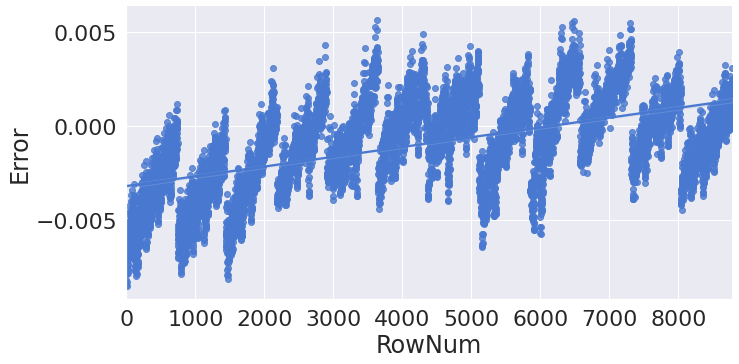

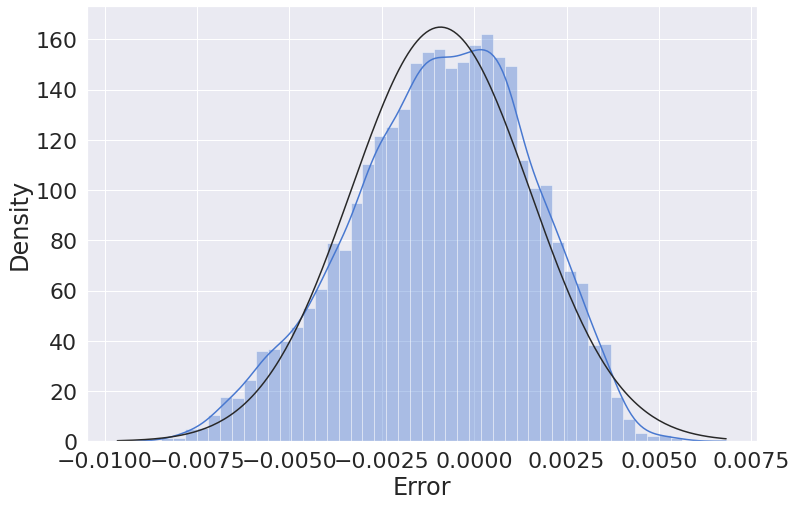

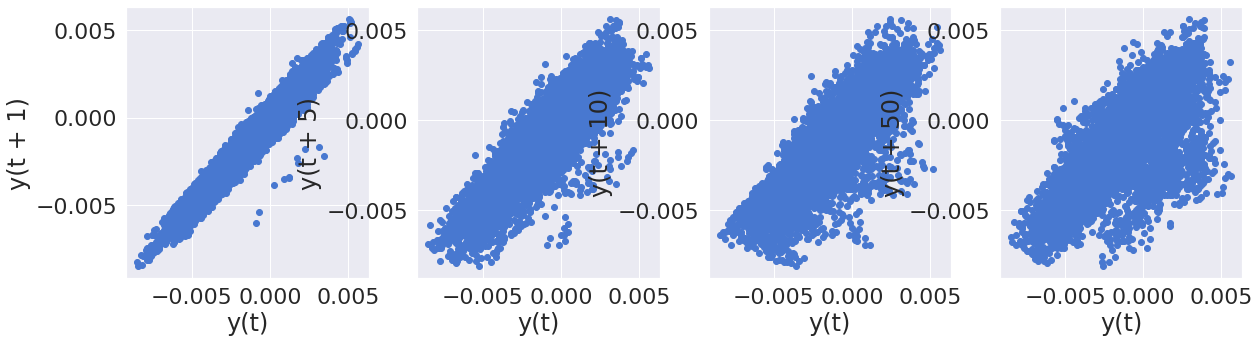

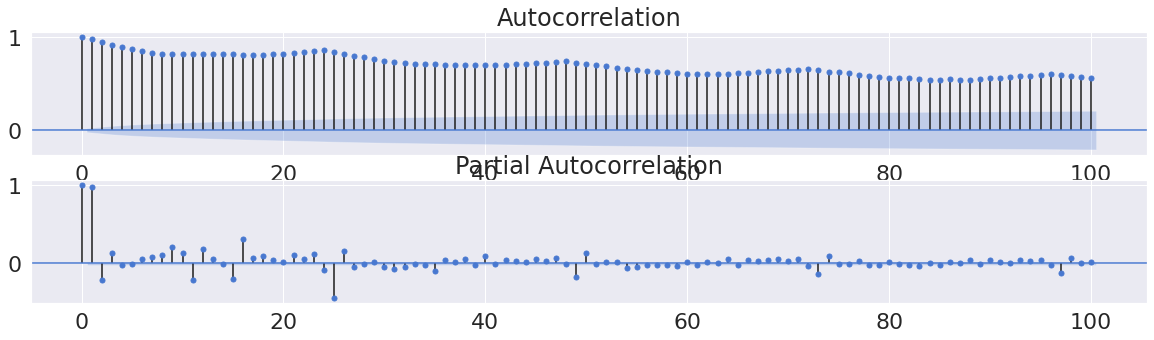

In [144]:
### Functionalize
### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(20,5))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(20,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

=> 
1. 정상성
2. 비 정규분포
3. 자기상관 있음
4. 등분산이 아님

In [145]:
fit_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rent_count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.019e+08
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        06:10:21   Log-Likelihood:                 9156.6
No. Observations:                8784   AIC:                        -1.829e+04
Df Residuals:                    8773   BIC:                        -1.821e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
rent_trend      -2.778e-05   5.54e-05     -0.502      0.616      -0.000    8.08e-05
rent_seasonal   -2.374e-05   3.01e-05     -0.788      0.431   -8.28e-05    3.53e-05
count_Day        -4.62e-06   5.46e-05     -0.085      0.933      -0.000       0.000
count_Week      -9.709e-06    4.5e-05     -0.216      0.829   -9.78e-05    7.84e-05
count_diff          1.0000   3.12e-05    3.2e+04      0.000       1.000       1.000
Year             4.349e-06   1.69e-06      2.579      0.010    1.04e-06    7.65e-06
Quarter            -0.0007      0.001     -0.845      0.398      -0.002       0.001
Day                -0.0002      0.000     -1.648      0.099      -0.000    3.23e-05
DayofWeek          -0.0002      0.000     -0.490      0.624      -0.001       0.001
rent_count_lag1     1.0000   3.07e-05   3.26e+04      0.000       1.000       1.000
rent_count_lag2   1.13e-06   2.74e-05      0.041      0.967   -5.26e-05    5.48e-05
==============================================================================
Omnibus:                    34233.415   Durbin-Watson:                   1.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      28130156822.366
Skew:                          93.594   Prob(JB):                         0.00
Kurtosis:                    8767.891   Cond. No.                     1.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residual index 0의 value는 진짜 outlier 인가?

In [153]:
Resid_tr_reg1[:5]

,Error,RowNum
DateTime,,
2020-01-01 00:00:00,7.99,0
2020-01-01 01:00:00,-0.01,0
2020-01-01 02:00:00,-0.01,1
2020-01-01 03:00:00,-0.01,2
2020-01-01 04:00:00,-0.01,3


In [156]:
pred_tr_reg1[:5]

array([24.00733902, 24.00772384, 34.00815811, 18.0084014 , 11.00847412])

In [151]:
Y_train[:5]

,rent_count
DateTime,
2020-01-01 00:00:00,32.00
2020-01-01 01:00:00,24.00
2020-01-01 02:00:00,34.00
2020-01-01 03:00:00,18.00
2020-01-01 04:00:00,11.00


In [147]:
df_gangdong.describe()

,rent_count,rent_trend,rent_seasonal,count_Day,count_Week,count_diff,Year,Quarter,Day,DayofWeek,rent_count_lag1,rent_count_lag2
count,"9,528.00","9,528.00","9,528.00","9,528.00","9,528.00","9,528.00","9,528.00","9,528.00","9,528.00","9,528.00","9,528.00","9,528.00"
mean,93.32,93.30,0.00,93.27,93.16,-0.00,"2,020.08",2.39,15.78,3.01,93.32,93.32
std,80.72,50.01,47.10,50.06,44.37,35.41,0.27,1.15,8.82,2.00,80.72,80.72
min,0.00,0.12,-78.02,0.00,11.98,-273.00,"2,020.00",1.00,1.00,0.00,0.00,0.00
25%,30.00,47.44,-29.71,47.38,48.02,-15.00,"2,020.00",1.00,8.00,1.00,30.00,30.00
50%,70.00,93.72,-5.14,93.73,96.84,0.00,"2,020.00",2.00,16.00,3.00,70.00,70.00
75%,137.00,137.06,32.27,136.84,131.86,16.00,"2,020.00",3.00,23.00,5.00,137.00,137.00
max,493.00,205.35,96.85,205.75,181.74,213.00,"2,021.00",4.00,31.00,6.00,493.00,493.00


# Feature Engineering

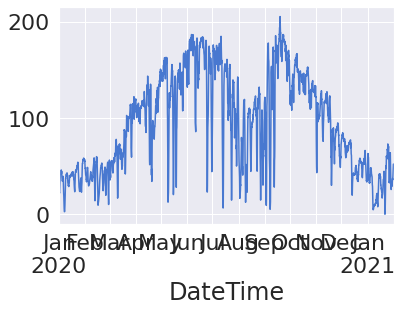

In [157]:
df_gangdong['rent_trend'].plot()

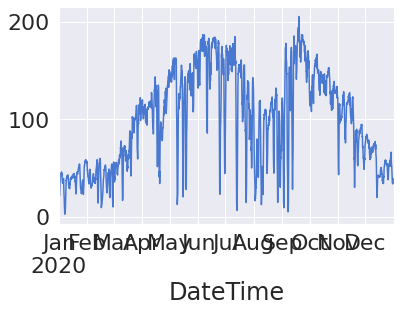

In [158]:
df_gangdong.loc[X_train.index, 'rent_trend'].plot()

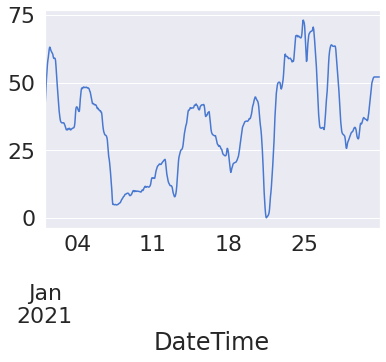

In [159]:
df_gangdong.loc[X_test.index, 'rent_trend'].plot()

- **'2021년 1월 trend는 2020년과 다르지 않다.'**고 가정한다.

In [161]:
df_gangdong.loc['2020-01-01':'2020-01-31', 'rent_trend'].shape

(744,)

In [162]:
df_gangdong.loc['2021-01-01':'2021-01-31', 'rent_trend'].shape

(744,)

In [163]:
df_gangdong.loc['2021-01-01':'2021-01-31', 'rent_trend'] = df_gangdong.loc['2020-01-01':'2020-01-31', 'rent_trend'].values

In [174]:
for i, v in enumerate(df_gangdong.loc['2021-01-01':'2021-01-31', 'rent_trend'].values):
  if v != df_gangdong.loc['2020-01-01':'2020-01-31', 'rent_trend'][i]:
    print('False')

In [176]:
df_gangdong.columns

Index(['rent_count', 'rent_trend', 'rent_seasonal', 'count_Day', 'count_Week',
       'count_diff', 'DateTime', 'Year', 'Quarter', 'Day', 'DayofWeek',
       'rent_count_lag1', 'rent_count_lag2'],
      dtype='object')

In [178]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(df_before, target):
    df_before_fe = df_before.copy()
    for col in target:
        df_before_fe.loc['2021-01-01':'2021-01-31', col] = df_before.loc['2020-01-01':'2020-01-31', col].values
    return df_before_fe
target = ['rent_trend', 'rent_seasonal', 'count_Day', 'count_Week', 'count_diff']
df_gangdong_fe = feature_engineering_year_duplicated(df_gangdong, target)

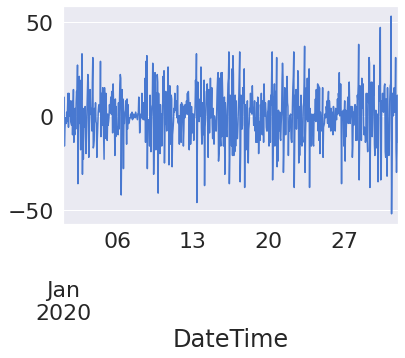

In [182]:
df_gangdong_fe.count_diff[:744].plot()

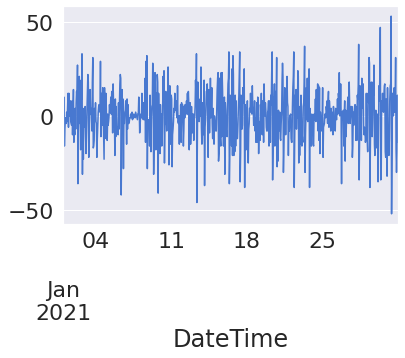

In [183]:
df_gangdong_fe.count_diff[-744:].plot()

In [201]:
df_gangdong.head()

,rent_count,rent_trend,rent_seasonal,count_Day,count_Week,count_diff,DateTime,Year,Quarter,Day,DayofWeek,rent_count_lag1,rent_count_lag2
DateTime,,,,,,,,,,,,,
2020-01-01 00:00:00,32.00,23.21,-22.35,23.29,29.80,-8.00,2020-01-01 00:00:00,2020,1,1,2,32.00,32.00
2020-01-01 01:00:00,24.00,23.21,-38.56,23.29,29.80,-8.00,2020-01-01 01:00:00,2020,1,1,2,32.00,32.00
2020-01-01 02:00:00,34.00,23.21,-56.46,23.29,29.80,10.00,2020-01-01 02:00:00,2020,1,1,2,24.00,32.00
2020-01-01 03:00:00,18.00,23.21,-68.56,23.29,29.80,-16.00,2020-01-01 03:00:00,2020,1,1,2,34.00,24.00
2020-01-01 04:00:00,11.00,23.21,-78.02,23.29,29.80,-7.00,2020-01-01 04:00:00,2020,1,1,2,18.00,34.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rent_count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.681e+08
Date:                Mon, 05 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:14:34   Log-Likelihood:                 9156.7
No. Observations:                8784   AIC:                        -1.829e+04
Df Residuals:                    8771   BIC:                        -1.820e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
rent_trend      -2.662e-05   5.55e-05     -0.480      0.631      -0.000    8.22e-05
rent_seasonal    -2.37e-05   3.01e-05     -0.786      0.432   -8.28e-05    3.54e-05
count_Day       -5.436e-06   5.47e-05     -0.099      0.921      -0.000       0.000
count_Week      -1.213e-06   4.95e-05     -0.025      0.980   -9.82e-05    9.58e-05
count_diff          1.0000   3.13e-05    3.2e+04      0.000       1.000       1.000
Year             3.929e-06   1.57e-06      2.505      0.012    8.55e-07       7e-06
Day                -0.0002      0.000     -1.657      0.098      -0.000    3.14e-05
DayofWeek          -0.0002      0.000     -0.489      0.625      -0.001       0.001
rent_count_lag1     1.0000   3.07e-05   3.26e+04      0.000       1.000       1.000
rent_count_lag2  1.101e-06   2.74e-05      0.040      0.968   -5.26e-05    5.48e-05
Quarter_Dummy_2    -0.0022      0.004     -0.598      0.550      -0.009       0.005
Quarter_Dummy_3    -0.0024      0.003     -0.725      0.469      -0.009       0.004
Quarter_Dummy_4    -0.0028      0.003     -0.919      0.358      -0.009       0.003
==============================================================================
Omnibus:                    34233.100   Durbin-Watson:                   1.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      28127991832.238
Skew:                          93.591   Prob(JB):                         0.00
Kurtosis:                    8767.554   Cond. No.                     1.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,0.00,0.01,inf
Test,18.08,629.36,inf


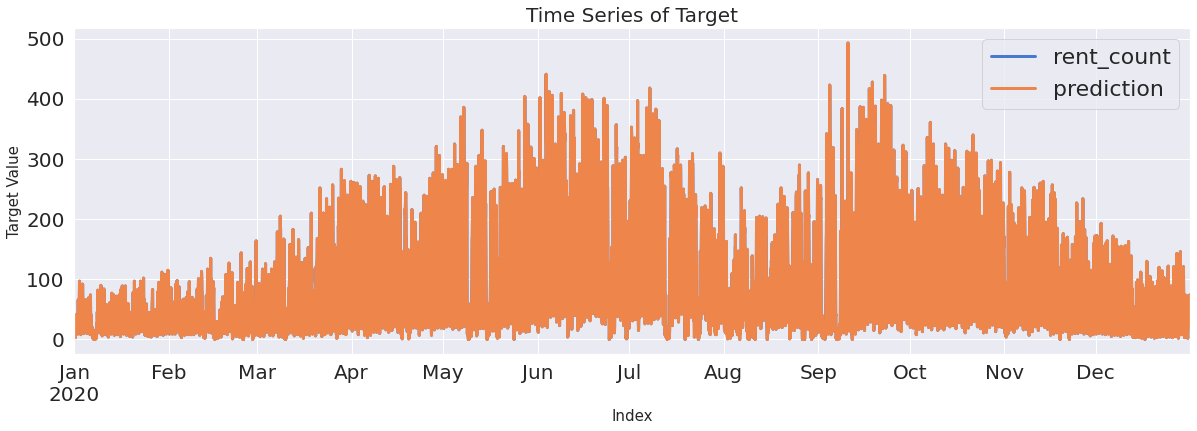

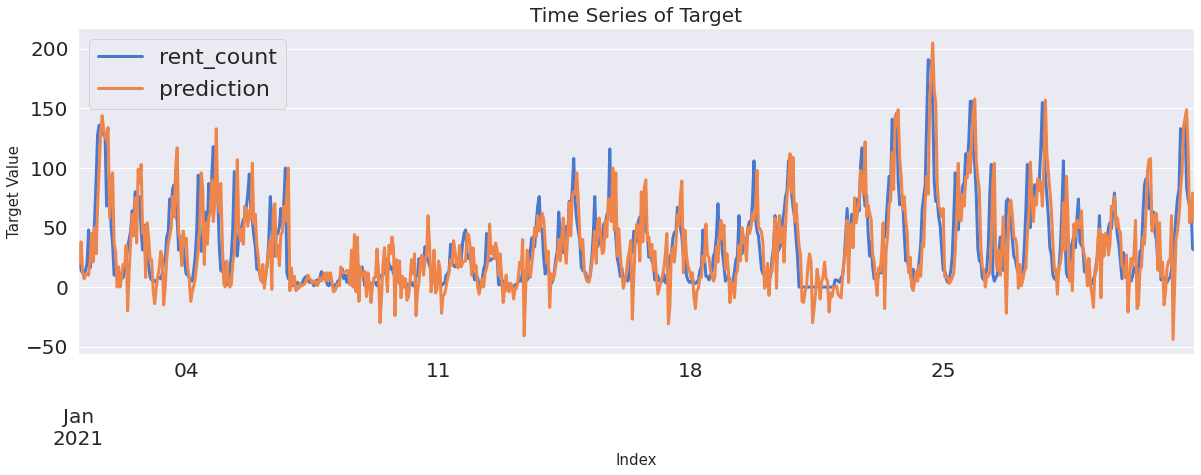

In [215]:
if 'Quarter' in df_gangdong.columns:
  if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in df_gangdong.columns]:
    df_gangdong = pd.concat([df_gangdong, pd.get_dummies(df_gangdong['Quarter'], prefix='Quarter_Dummy', drop_first=True)], axis=1)
    del df_gangdong['Quarter']



def feature_engineering_month_duplicated(df_before, target):
    df_before_fe = df_before.copy()
    for col in target:
        df_before_fe.loc['2021-01-01':'2021-01-31', col] = df_before.loc['2020-01-01':'2020-01-31', col].values
    return df_before_fe
target = ['rent_trend', 'rent_seasonal', 'count_Day', 'count_Week', 'count_diff']
df_gangdong = feature_engineering_month_duplicated(df_gangdong, target)

Y_colname = ['rent_count']
X_remove = ['DateTime']
X_colname = [x for x in df_gangdong.columns if x not in Y_colname+X_remove]

data_train = df_gangdong.loc[df_gangdong.index < '2021-01-01', :]
data_test = df_gangdong.loc[df_gangdong.index >= '2021-01-01', :]

Y_train_feR = data_train[Y_colname]
X_train_feR = data_train[X_colname]
Y_test_feR = data_test[Y_colname]
X_test_feR = data_test[X_colname]


### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
target = ['rent_count_lag1', 'rent_count_lag1']
X_test_feR= feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)

fit_reg1_feR = sm.OLS(Y_train_feR, X_train_feR).fit()
display(fit_reg1_feR.summary())

pred_tr_reg1_feR = fit_reg1_feR.predict(X_train_feR).values
pred_te_reg1_feR = fit_reg1_feR.predict(X_test_feR).values

# Evaluation
Score_reg1_feR, Resid_tr_reg1_feR, Resid_te_reg1_feR = evaluation_trte(Y_train_feR, pred_tr_reg1_feR,
                                                                   Y_test_feR, pred_te_reg1_feR, graph_on=True)
display(Score_reg1_feR)



In [216]:
Resid_tr_reg1_feR[:10]

,Error
DateTime,
2020-01-01 00:00:00,7.99
2020-01-01 01:00:00,-0.01
2020-01-01 02:00:00,-0.01
2020-01-01 03:00:00,-0.01
2020-01-01 04:00:00,-0.01
2020-01-01 05:00:00,-0.01
2020-01-01 06:00:00,-0.01
2020-01-01 07:00:00,-0.01
2020-01-01 08:00:00,-0.01


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-5.85,0.07,0.01,0.00,0.00,0.00,0.01,0.00
p-value,0.00,0.10,0.00,1.00,1.00,1.00,1.00,0.00
Used Lag,36.00,37.00,nan,nan,nan,nan,nan,NaN
Used Observations,"8,747.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-114,228.89",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


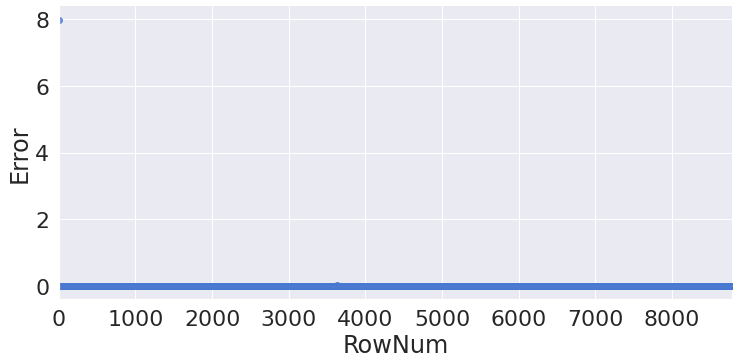

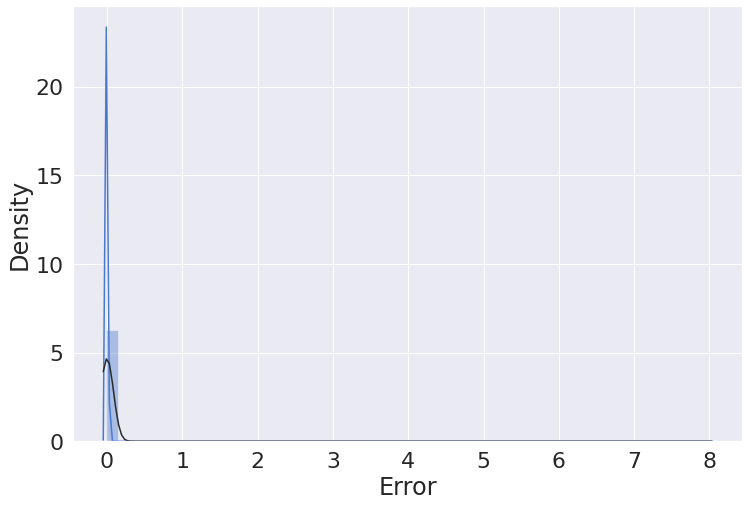

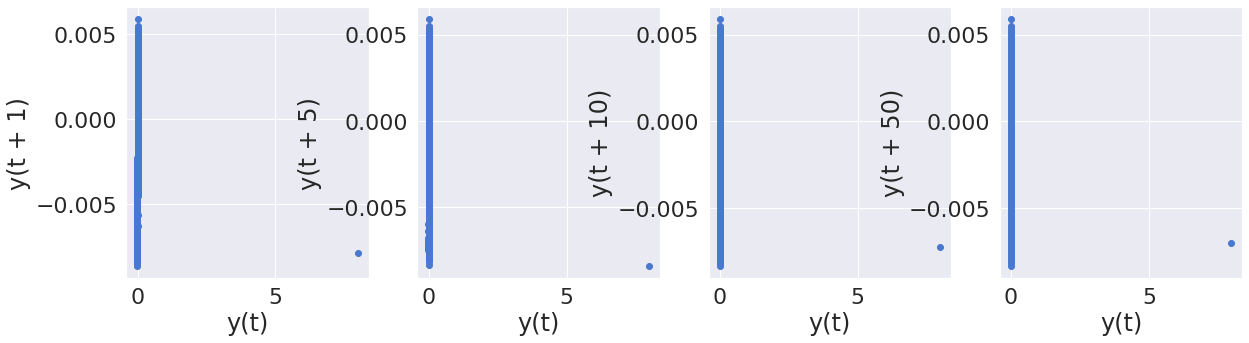

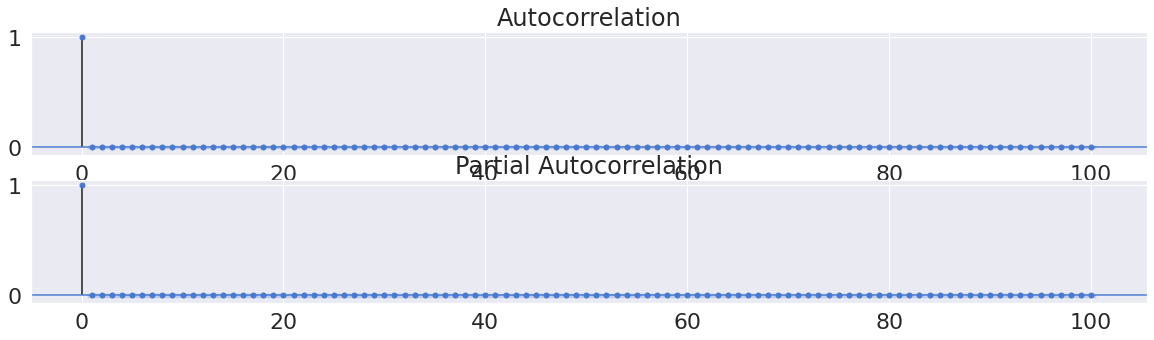

In [213]:
# # Error Analysis
error_analysis(Resid_tr_reg1_feR, ['Error'], X_train_feR, graph_on=True)

In [214]:
df_gangdong

,rent_count,rent_trend,rent_seasonal,count_Day,count_Week,count_diff,DateTime,Year,Day,DayofWeek,rent_count_lag1,rent_count_lag2,Quarter_Dummy_2,Quarter_Dummy_3,Quarter_Dummy_4
DateTime,,,,,,,,,,,,,,,
2020-01-01 00:00:00,32.00,23.21,-22.35,23.29,29.80,-8.00,2020-01-01 00:00:00,2020,1,2,32.00,32.00,0,0,0
2020-01-01 01:00:00,24.00,23.21,-38.56,23.29,29.80,-8.00,2020-01-01 01:00:00,2020,1,2,32.00,32.00,0,0,0
2020-01-01 02:00:00,34.00,23.21,-56.46,23.29,29.80,10.00,2020-01-01 02:00:00,2020,1,2,24.00,32.00,0,0,0
2020-01-01 03:00:00,18.00,23.21,-68.56,23.29,29.80,-16.00,2020-01-01 03:00:00,2020,1,2,34.00,24.00,0,0,0
2020-01-01 04:00:00,11.00,23.21,-78.02,23.29,29.80,-7.00,2020-01-01 04:00:00,2020,1,2,18.00,34.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31 19:00:00,74.00,53.48,62.70,57.25,42.45,-18.00,2021-01-31 19:00:00,2021,31,6,84.00,137.00,0,0,0
2021-01-31 20:00:00,68.00,50.92,53.66,57.25,42.61,-30.00,2021-01-31 20:00:00,2021,31,6,74.00,84.00,0,0,0
2021-01-31 21:00:00,69.00,48.77,43.02,56.08,42.69,-19.00,2021-01-31 21:00:00,2021,31,6,68.00,74.00,0,0,0
